# Spectrogram classification 모델 구현

### 목표
---
2차원 Spectrogram 데이터를 입력받아 Text 라벨을 출력하는 모델을 기본버전과 Skip-connection 버전으로 나뉘어 학습시켜본다.

## 학습 데이터 준비
---

In [15]:
delete_vals()

### 데이터 처리와 분류

- 저장된 음성 데이터 불러오기

In [16]:
speech_data = load_data()

DATA_AMOUNT = 50000
wav_vals = speech_data["wav_vals"][:DATA_AMOUNT]
label_vals = speech_data["label_vals"][:DATA_AMOUNT]

- Spectrogram 생성

In [17]:
spec_vals = np.array([ wav2spec(wav) for wav in wav_vals ])

(50000, 130, 126)


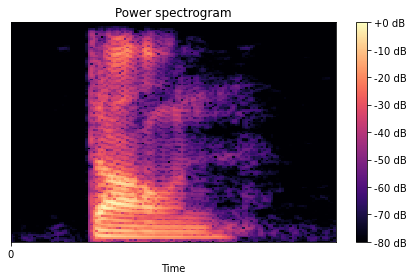

In [18]:
print(spec_vals.shape)
show_spectrogram(spec_vals[60])

#### 라벨 데이터 처리하기

In [19]:
label_value, label_data = get_label_data(label_vals)

In [20]:
label_data

array([ 3,  3,  3, ..., 11, 11, 11])

#### sklearn의 train_test_split함수를 이용하여 train, test 분리

In [21]:
from sklearn.model_selection import train_test_split

train_spec, test_spec, train_label, test_label = train_test_split(spec_vals, 
                                                                  label_data, 
                                                                  test_size=0.2,
                                                                  shuffle=True)

train_spec = train_spec.reshape([-1, 130, 126, 1]) # add channel for CNN
test_spec = test_spec.reshape([-1,  130, 126, 1])

In [22]:
print("train data : ", train_spec.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_spec.shape)
print("test labels : ", test_label.shape)

train data :  (40000, 130, 126, 1)
train labels :  (40000,)
test data :  (10000, 130, 126, 1)
test labels :  (10000,)


In [53]:
test_spec[0]

array([[[7.2873267e-04],
        [5.3130696e-04],
        [9.9507815e-06],
        ...,
        [3.0216143e-02],
        [3.6090055e-01],
        [6.9839555e-01]],

       [[7.4979797e-04],
        [2.4998267e-04],
        [2.9223293e-04],
        ...,
        [1.2002578e-01],
        [4.7989976e-01],
        [7.8378719e-01]],

       [[6.2743889e-04],
        [7.8956760e-04],
        [1.0085087e-03],
        ...,
        [1.5542549e-01],
        [8.5403806e-01],
        [2.0278819e+00]],

       ...,

       [[2.3692324e-05],
        [1.3074941e-05],
        [5.5062865e-06],
        ...,
        [3.1193448e-04],
        [1.1258192e-03],
        [7.0366712e-04]],

       [[2.2257904e-05],
        [1.0339760e-05],
        [2.6170187e-06],
        ...,
        [2.0119606e-04],
        [7.8241434e-04],
        [8.1444369e-04]],

       [[2.0460160e-05],
        [1.0663136e-05],
        [1.3362192e-06],
        ...,
        [1.7405688e-04],
        [8.7783579e-04],
        [1.3776519e-03]]

In [55]:
spec_vals[0].shape

(130, 126)

### 학습을 위한 하이퍼 파리미터 설정

In [23]:
batch_size = 32
max_epochs = 10

### 데이터셋 구성


In [24]:
import tensorflow as tf

train_dataset = get_dataset(train_spec, train_label, batch_size)
test_dataset = get_dataset(test_spec, test_label, batch_size)
print(train_dataset)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


## 모델 구성 및 학습
---

### 2차원 Spectrogram 데이터를 처리하는 모델 구성

- 기본 버전 모델

In [25]:
class BasicModel(Model):
    def __init__(self, batch_size, max_epochs, checkpoint_dir):
        Model.__init__(self, batch_size, max_epochs, checkpoint_dir)
        self.set_model()
        
    def set_model(self):
        input_tensor = layers.Input(shape=self.input_data_shape)
        
        x = layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu')(input_tensor)
        x = layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)

        x = layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(x)
        x = layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)

        x = layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu')(x)
        x = layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu')(x)
        x = layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)

        x = layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='relu')(x)
        x = layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='relu')(x)
        x = layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Flatten()(x)
        x = layers.Dense(256)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        output_tensor = layers.Dense(12)(x)

        self.model = tf.keras.Model(input_tensor, output_tensor)
        self.model.summary()

In [26]:
basic_model_checkpoint_dir = "{}{}_{}_{}".format(workspace_path + '/models/',"basic",
                                                 batch_size, max_epochs)
basic_model = BasicModel(batch_size, max_epochs, basic_model_checkpoint_dir)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0     

- skip-connection 버전 모델

In [27]:
class SkipConnectionModel(Model):
    def __init__(self, batch_size, max_epochs, checkpoint_dir):
        Model.__init__(self, batch_size, max_epochs, checkpoint_dir)
        self.set_model()
    
    def set_model(self):
        input_tensor = layers.Input(shape=self.input_data_shape)

        x = layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu')(input_tensor)
        x = layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu')(x)
        skip_1 = layers.MaxPool2D()(x)

        x = layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(skip_1)
        x = layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(x)
        x = tf.concat([x, skip_1], -1)
        skip_2 = layers.MaxPool2D()(x)

        x = layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu')(skip_2)
        x = layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu')(x)
        x = layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu')(x)
        x = tf.concat([x, skip_2], -1)
        skip_3 = layers.MaxPool2D()(x)

        x = layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='relu')(skip_3)
        x = layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='relu')(x)
        x = layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='relu')(x)
        x = tf.concat([x, skip_3], -1)
        x = layers.MaxPool2D()(x)
        x = layers.Dropout(0.3)(skip_3)

        x = layers.Flatten()(x)
        x = layers.Dense(256)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        output_tensor = layers.Dense(12)(x)

        self.model = tf.keras.Model(input_tensor, output_tensor)
        self.model.summary()

In [28]:
sc_model_checkpoint_dir = "{}{}_{}_{}".format(workspace_path + '/models/',"sc",
                                                 batch_size, max_epochs)
skip_connection_model = SkipConnectionModel(batch_size, max_epochs,sc_model_checkpoint_dir)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 130, 126, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 130, 126, 32) 9248        conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 65, 63, 32)   0           conv2d_11[0][0]                  
____________________________________________________________________________________________

### 모델 학습

In [29]:
basic_model.compile_model()
basic_model.train(train_dataset, test_dataset, len(test_label) // batch_size)

Train for 312 steps, validate for 312 steps
Epoch 1/10
311/312 [============================>.] - ETA: 0s - loss: 1.6511 - accuracy: 0.4560
Epoch 00001: val_loss improved from inf to 1.51676, saving model to /home/aiffel-dj1/workspace/aiffel-exploation-workspace/E05_spectrogram_classification/models/basic_32_10
312/312 [==============================] - 24s 78ms/step - loss: 1.6488 - accuracy: 0.4569 - val_loss: 1.5168 - val_accuracy: 0.7126
Epoch 2/10
311/312 [============================>.] - ETA: 0s - loss: 0.7376 - accuracy: 0.7688
Epoch 00002: val_loss improved from 1.51676 to 0.65199, saving model to /home/aiffel-dj1/workspace/aiffel-exploation-workspace/E05_spectrogram_classification/models/basic_32_10
312/312 [==============================] - 20s 64ms/step - loss: 0.7367 - accuracy: 0.7691 - val_loss: 0.6520 - val_accuracy: 0.8006
Epoch 3/10
311/312 [============================>.] - ETA: 0s - loss: 0.5222 - accuracy: 0.8357
Epoch 00003: val_loss improved from 0.65199 to 0.405

In [31]:
skip_connection_model.compile_model()
skip_connection_model.train(train_dataset, test_dataset, len(test_label) // batch_size)

Train for 312 steps, validate for 312 steps
Epoch 1/10
311/312 [============================>.] - ETA: 0s - loss: 1.7442 - accuracy: 0.4363
Epoch 00001: val_loss improved from inf to 1.41270, saving model to /home/aiffel-dj1/workspace/aiffel-exploation-workspace/E05_spectrogram_classification/models/sc_32_10
312/312 [==============================] - 22s 71ms/step - loss: 1.7424 - accuracy: 0.4369 - val_loss: 1.4127 - val_accuracy: 0.5499
Epoch 2/10
311/312 [============================>.] - ETA: 0s - loss: 0.8645 - accuracy: 0.7306
Epoch 00002: val_loss improved from 1.41270 to 0.65888, saving model to /home/aiffel-dj1/workspace/aiffel-exploation-workspace/E05_spectrogram_classification/models/sc_32_10
312/312 [==============================] - 19s 62ms/step - loss: 0.8635 - accuracy: 0.7310 - val_loss: 0.6589 - val_accuracy: 0.7978
Epoch 3/10
311/312 [============================>.] - ETA: 0s - loss: 0.6100 - accuracy: 0.8119
Epoch 00003: val_loss improved from 0.65888 to 0.48327, sa

### 학습 결과

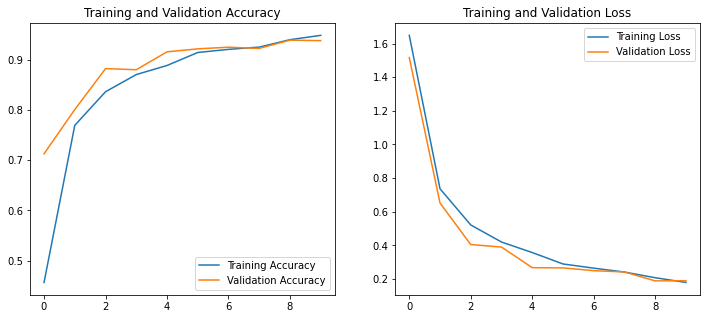

In [32]:
diplay_train_history(basic_model.history)

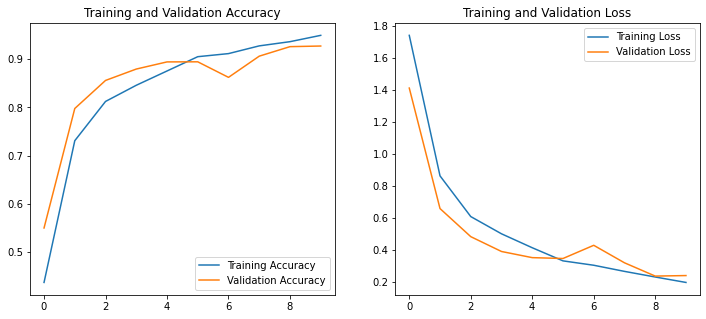

In [33]:
diplay_train_history(skip_connection_model.history)

- 확인결과 overfitting은 되지 않았지만 training loss와 test loss가 같이 감소하는 추세가 너무 뚜렷하여 underfitting이 의심된다.

## 모델 성능 평가
---

### Evaluation

In [34]:
basic_model.evaluate(test_dataset, steps=(test_spec.shape[0] // batch_size))

312/312 [==============================] - 5s 17ms/step - loss: 0.1902 - accuracy: 0.9375
loss value: 0.190
accuracy value: 93.7500%


In [36]:
skip_connection_model.evaluate(test_dataset, steps=(test_spec.shape[0] // batch_size))

312/312 [==============================] - 5s 16ms/step - loss: 0.2399 - accuracy: 0.9274
loss value: 0.240
accuracy value: 92.7384%


- evaluation 결과, 두 모델 각기 93%, 92%의 정확도를 보였다.

### Model Test

In [120]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred = basic_model.model(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))
batch_xs = batch_xs.reshape([130, 126])
batch_xs = spec2wav(batch_xs)
ipd.Audio(batch_xs, rate=8000)

label :  right


In [121]:
print("y_pred: " + str(inv_label_value[np.argmax(y_pred)]))

y_pred: right


- 예측 결과와 실제 라벨이 같음을 확인하여 예측이 정상적으로 작동하고 있음을 확인 할 수 있었다.

## 결론
---

### 요약
- 목표 : 2차원 Spectrogram 데이터를 입력받는 classification 모델은 일반적인 버전과 skip-connection을 활용한 버전 두가지로 구현해 본다.
- 프로젝트 진행 과정
    - 데이터 전처리
        - [캐글 음성인식 챌리지 데이터](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge)를 다운로드 받는다.
        - 데이를 음성(wave)와 라벨 데이터로 분리한다.
        - 음성 데이터를 2차원의 spectogram으로 변환시킨다.
    - 모델 설계/훈련 : 2D convoluction layer와 2D MaxPooling을 혼합하여 모델을 설계한다. 이때, skip-connection을 포함하는 모델과 그렇지 않은 모델 두개를 정의한다. 모델을 훈련시키고 accuracy와 loss를 구한다. 이때, accuarcy와 loss를 그래프로 나타내어 추이를 확인한다.
    - 평가 : evaluation을 통하여 모델을 평가한다.

### 프로젝트 평가

1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였는가? 스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었는가?
    - 음성 데이터를 모두 Spectogram으로 변환하는 것에 성공하였고 spectogram 시각화에 성공하였다. train/test 데이터셋을 4:1 비율로 구성하였다.
2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동하였는가? 스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하였는가?
    - spectogram을 입력 받는 음성인식 모델이 정상적으로 작동하였다. 
3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였는가? evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재하는가?
    - evaluation 결과, 두 모델 각기 93%, 92%의 정확도를 보였다.

### 회고
- 이번 프로젝트의 쟁점은 gpu 관리였다. 초반에 train을 올리기만 하면 커널이 죽어 모델 학습을 시작조차 할 수 없었다. 원인은 tensorflow에서 gpu를 사용하지 않고 cpu를 사용하고 있다는 것이었다. 확인결과 tensorflow-gpu 패키지가 설치되어 있지 않았고 이를 정정하고난 후 모델 학습을 시작할 수 있었다. 이후로도 종종 gpu와 커널의 캐시문제로 커널이 죽어버리는 경우가 발생하였는다. 커널을 적절히 재부팅해주고 code collection에 정의한 init_gpu 함수를 통하여 gpu 초기화를 진행해주는 것으로 해결 할 수 있었다.

## Code Collection
---

#### import packages

In [1]:
from tensorflow.keras import layers
import os
import tensorflow as tf
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from abc import *
from pathlib import Path

workspace_path = os.getenv("HOME")+'/workspace/aiffel-exploation-workspace/E05_spectrogram_classification'

#### load_data

In [2]:
def load_data():
    data_path = workspace_path + '/data/speech_wav_8000.npz'
    speech_data = np.load(data_path)
    return speech_data

#### wav2spec

In [3]:
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

#### spec2wav

In [4]:
def spec2wav(spec): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.istft(spec))
    return D

#### play

In [5]:
import IPython.display as ipd

def play(x, label):
    print("label : ", label)
    ipd.Audio(x, rate=8000)

#### show_spectrogram

In [6]:
def show_spectrogram(spec):
    librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
    plt.title('Power spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.xticks(range(0, 1))
    plt.tight_layout()
    plt.show()

#### get_label_data

In [7]:
def get_label_data(label_vals):
    target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
    others = ['unknown', 'silence']
    label_value = target_list + others

    new_label_value = dict()
    for i, l in enumerate(label_value): new_label_value[l] = i
    label_value = new_label_value

    label_data = np.array([ label_value[v[0]] for v in label_vals ])
    return label_value, label_data

#### model : abstract class

In [8]:
class Model(metaclass=ABCMeta):
    def __init__(self, batch_size, max_epochs, checkpoint_dir):
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.checkpoint_dir = checkpoint_dir
        self.input_data_shape = (130, 126, 1)
        self.model = None
        self.cp_callback = tf.keras.callbacks.ModelCheckpoint(
                                checkpoint_dir,
                                save_weights_only=True,
                                monitor='val_loss',
                                mode='auto',
                                save_best_only=True,
                                verbose=1)
        self.is_model_trained = False
        
    @abstractmethod
    def set_model(self):
        pass
    
    def compile_model(self):
        optimizer = tf.keras.optimizers.Adam(1e-4)
        self.model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                           optimizer=optimizer,
                           metrics=['accuracy'])
        
    def train(self, train_dataset, val_dataset, steps):
        self.history = self.model.fit(train_dataset, epochs=self.max_epochs,
                            steps_per_epoch=steps,
                            validation_data=val_dataset,
                            validation_steps=steps,
                            callbacks=[self.cp_callback])
        self.is_model_trained = True
    
    def evaluate(self, test_dataset, steps):
        result = None
        
        if self.is_model_trained:
            result = self.model.evaluate(test_dataset, steps=steps)
        elif os.path.isfile(self.checkpoint_dir):
            self.model.load_weights(self.checkpoint_dir)
            result = self.model.evaluate(test_dataset, steps=steps)
            
        if result != None:
            print("loss value: {:.3f}".format(result[0]))
            print("accuracy value: {:.4f}%".format(result[1]*100))
        else :
            print("train this model first 🙏")

#### diplay_train_history

In [9]:
import matplotlib.pyplot as plt

def diplay_train_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

#### get_dataset

In [10]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [11]:
def get_dataset(X, y, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.map(one_hot_label)
    dataset = dataset.repeat().batch(batch_size=batch_size)
    return dataset

#### init_gpu

In [3]:
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [2]:
%config Completer.use_jedi = False